# 0. Import Library

In [1]:
import torch
import torch.nn.functional as F
import tqdm
import time
import pickle
import matplotlib.pyplot as plt
from replay.replay import ReplayBuffer, BufferFields, set_buffer_dim

# 1. Load Collected Data

In [2]:
device_id = 2
with open('pkl/walker_replay_2state.pkl', 'rb') as fp:
    replay_buffer = pickle.load(fp)
    
#replay_buffer._buffer['state'][:, 8:] = replay_buffer._buffer['state'][:, 8:]/10
#replay_buffer._buffer['prev_state'][:, 8:] = replay_buffer._buffer['prev_state'][:, 8:]/10
#replay_buffer._buffer['next_state'][:, 8:] = replay_buffer._buffer['next_state'][:, 8:]/10

print(replay_buffer._buffer.keys())
print(replay_buffer._buffer['state'].size(), replay_buffer._buffer['state'].device)
print(replay_buffer._buffer['action'].size(), replay_buffer._buffer['action'].device)
print(replay_buffer._buffer['reward'].size(), replay_buffer._buffer['reward'].device)
print(replay_buffer._buffer['prev_state'].size(), replay_buffer._buffer['prev_state'].device)
print(replay_buffer._buffer['prev_action'].size(), replay_buffer._buffer['prev_action'].device)
set_buffer_dim(17, 6) # walker
#set_buffer_dim(11, 3) # hopper

dict_keys(['state', 'action', 'reward', 'done', 'next_state', 'end', 'prev_state', 'prev_action'])
torch.Size([1000000, 17]) cuda:2
torch.Size([1000000, 6]) cuda:2
torch.Size([1000000, 1]) cuda:2
torch.Size([1000000, 17]) cuda:2
torch.Size([1000000, 6]) cuda:2


# 2. Load Agent

In [3]:
from agent.model_agent import ModelAgent
from agent.disc_agent import DiscriminateAgent

model_agent = ModelAgent(
    device_id,
    trans_hidden_size=[256, 256, 256, 256],
    reward_hidden_size=[256, 256, 256, 256],
    model_activation=torch.nn.LeakyReLU,
    use_batchnorm=False,
    dropout_prob=None,
    deterministic=True)
print(vars(model_agent))

disc_agent = DiscriminateAgent(
    device_id,
    hidden_size=[256, 256],
    activation=torch.nn.ReLU
)
print(vars(disc_agent))

{'_deterministic': True, '_device_id': 2, '_logger': <RootLogger root (WARNING)>, '_transition_mlp': WorldMlp(
  (_model): Sequential(
    (0): Linear(in_features=23, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=256, out_features=34, bias=True)
  )
), '_reward_mlp': WorldMlp(
  (_model): Sequential(
    (0): Linear(in_features=40, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=256, out

# 3. Setup Data loader and Training Process

In [4]:
#training_range = (0, int(90e3))
training_range = (0, int(100e3))
#validation_range = (int(90e3), int(100e3))
batch_size = 32
n_epoch = 5
disc_lr = 1e-4
model_lr = 1e-3
reward_lr = 1e-4
weight_decay = 0

# setup optimizer
#model_params = list(agent.transition_params()) + list(agent.reward_params())
t_optim = torch.optim.AdamW(model_agent.transition_params(), lr=model_lr, weight_decay=weight_decay)
r_optim = torch.optim.AdamW(model_agent.reward_params(), lr=reward_lr, weight_decay=weight_decay)
d_optim = torch.optim.Adam(disc_agent.params(), lr=disc_lr)

In [5]:
def train_disc(model_agent, disc_agent, d_optim):
    errors = []
    losses = []
    for it in tqdm.trange(0, int(data_size/batch_size)):
        # get a batch of data
        real_samples = replay_buffer.range_sample(batch_size, training_range[0], training_range[1], device_id)
        
        # get predict
        next_state_diff = model_agent.transition(real_samples['state'], real_samples['action'])
        #next_state_diff = model_agent.transition(real_samples['state']-real_samples['prev_state'], real_samples['action'])
        next_state_pred = real_samples['state'] + next_state_diff
        reward_pred = model_agent.reward(real_samples['state'], real_samples['action'], next_state_pred.detach())
        #reward_pred = model_agent.reward(real_samples['state']-real_samples['prev_state'], real_samples['action'], next_state_pred.detach())
        
        imag_samples = {}
        imag_samples['state'] = real_samples['state']    
        imag_samples['action'] = real_samples['action']    
        imag_samples['done'] = real_samples['done']
        imag_samples['reward'] = reward_pred.detach()
        imag_samples['next_state'] = next_state_pred.detach()   
        
        samples = {}    
        for k in BufferFields.keys():    
            if k == 'end':    
                continue    
            samples[k] = torch.cat((real_samples[k], imag_samples[k]), dim=0)    

        # soft labels    
        true_labels = torch.full((batch_size,), .8) + torch.randn((batch_size,))/10.0    
        fake_labels = torch.full((batch_size,), .2) + torch.randn((batch_size,))/10.0
        #true_labels = torch.full((batch_size,), 1)
        #fake_labels = torch.full((batch_size,), 0)
        labels = torch.cat((true_labels, fake_labels)).view(-1,1).to(device_id)    

            
        logits, pred = disc_agent.discriminate(    
              samples['state'].detach(),    
              samples['action'].detach(),    
              samples['reward'].detach(),    
              samples['done'].detach(),    
              samples['next_state'].detach())    
        error = (pred-labels).abs().sum()/(2*batch_size)    

        loss = F.binary_cross_entropy_with_logits(logits, labels)
        
        d_optim.zero_grad()
        loss.backward()    
        d_optim.step()    

        errors.append(error)    
        losses.append(loss)
        
    return errors, losses

In [6]:
def range_shuffle_sample(buffer, range_low, range_high):
    shuffled_samples = {}
    range_size = range_high - range_low
    _, indices = torch.rand(range_size).sort()
    for key in buffer.keys():
        range_data = buffer[key][range_low:range_high, :]
        shuffled_samples[key] = range_data[indices,:]    
    return shuffled_samples

buffer = {
    'kkk': torch.tensor([
        [1,2,3],
        [4,5,6],
        [7,8,9],
        [10, 11, 12]
    ])}
print(range_shuffle_sample(buffer, 0, 4))

t = buffer['kkk']
idx = torch.tensor([
    [1,2,3],
    [1,2,3]])
t[idx].shape

{'kkk': tensor([[ 4,  5,  6],
        [10, 11, 12],
        [ 1,  2,  3],
        [ 7,  8,  9]])}


torch.Size([2, 3, 3])

In [7]:
sample = replay_buffer.range_sample(batch_size, training_range[0], training_range[1], device_id)
sample['state'].shape

torch.Size([32, 17])

In [8]:
data_size = training_range[1] - training_range[0]

print('data_size:', data_size)

losses = {}
losses['transition'] = []
losses['reward'] = []
losses['gan'] = []
losses['total'] = []
losses['disc'] = []
losses['disc_errors'] = []

shuffled_samples = range_shuffle_sample(replay_buffer._buffer, training_range[0], training_range[1])
model_agent.set_data_statistics(shuffled_samples['state'], shuffled_samples['action'], shuffled_samples['next_state'])

for epoch in range(n_epoch):
    print('epoch:', epoch)
    
    #disc_errors, disc_losses = train_disc(model_agent, disc_agent, d_optim)
    #print('disc_errors:', disc_errors[-1])
    #print('disc_losses:', disc_losses[-1])
    #losses['disc_errors'].extend(disc_errors)
    #losses['disc'].extend(disc_losses)
    
    shuffled_samples = range_shuffle_sample(replay_buffer._buffer, training_range[0], training_range[1])
    
    for it in tqdm.trange(0, int(data_size/batch_size)):
        
        # get a batch of data
        #sample = replay_buffer.range_sample(batch_size, training_range[0], training_range[1], device_id)
        sample = {}
        for key in BufferFields.keys():
            sample[key] = shuffled_samples[key][it*batch_size: (it+1)*batch_size, :]
            
        #normalized_state, normalized_action, normalized_next_state = model_agent.preprocess(sample['state'], sample['action'], sample['next_state'])
        
        # get predict
        next_state_diff = model_agent.transition(sample['state'], sample['action'])
        #next_state_diff = model_agent.transition(sample['state'], sample['state']-sample['prev_state'], sample['action'], sample['prev_action'])
        next_state_pred = sample['state'] + next_state_diff
        reward_pred = model_agent.reward(sample['state'], sample['action'], next_state_pred.detach())
        
        transition_reg_loss = F.mse_loss(next_state_pred, sample['next_state'])
        reward_reg_loss = F.mse_loss(reward_pred, sample['reward'])

        
        #mu, logvar = model_agent.transition(sample['state'], sample['action'], ret_logvar=True)
        #transition_reg_loss = (mu - (sample['next_state'] - sample['state'])).square() * torch.exp(-logvar) + logvar
        #transition_reg_loss = transition_reg_loss.mean(-1).mean(-1)
        
        #next_state_pred = sample['state'] + mu
        #reward_pred = model_agent.reward(sample['state'], sample['action'], next_state_pred.detach())
        #reward_reg_loss = F.mse_loss(reward_pred, sample['reward'])
        
        
        # gan loss
        #logits, pred = disc_agent.discriminate(    
        #        sample['state'],    
        #        sample['action'],
        #        sample['done'],
        #        reward_pred,
        #        next_state_pred)
        #true_labels = torch.full((batch_size, 1), .8, dtype=logits.dtype, device=logits.device) + torch.randn((batch_size, 1), dtype=logits.dtype, device=logits.device)/10.0    
        #gan_loss = F.binary_cross_entropy_with_logits(logits, true_labels)
        
        
        losses['transition'].append(transition_reg_loss)
        losses['reward'].append(reward_reg_loss)
        #losses['gan'].append(gan_loss)
        
        total_loss = transition_reg_loss + reward_reg_loss #+ 0.0 * gan_loss
        #total_loss = gan_loss
        losses['total'].append(total_loss)
        
        t_optim.zero_grad()
        r_optim.zero_grad()
        
        #transition_reg_loss.backward()
        #reward_reg_loss.backward()
        #gan_loss.backward()
        total_loss.backward()
        
        t_optim.step()
        r_optim.step()
        
    print('transition_reg_loss:', transition_reg_loss)
    print('reward_reg_loss:', reward_reg_loss)
    print('total_loss:', total_loss)

  0%|          | 0/3125 [00:00<?, ?it/s]

data_size: 100000
data_statistics: tensor([ 0.3796, -0.6524, -0.8319, -0.8223,  0.1097, -1.0044, -0.6855,  0.0596,
         0.1766, -0.1304, -0.2285, -0.4034, -0.0357,  0.0322, -0.3818, -0.0675,
        -0.0606], device='cuda:2') tensor([0.3577, 2.6335, 0.9130, 0.9758, 0.7650, 1.0197, 0.9265, 0.7574, 1.1927,
        1.2660, 5.5567, 6.0906, 5.3109, 6.8532, 5.9319, 5.1665, 6.6384],
       device='cuda:2') tensor([ 0.0719,  0.1861,  0.0989, -0.0140,  0.2439,  0.0616], device='cuda:2') tensor([0.6976, 0.7323, 0.7502, 0.7217, 0.7361, 0.7540], device='cuda:2') tensor([ 0.3785, -0.6530, -0.8329, -0.8231,  0.1097, -1.0056, -0.6863,  0.0595,
         0.1767, -0.1304, -0.2287, -0.4034, -0.0360,  0.0314, -0.3815, -0.0680,
        -0.0619], device='cuda:2') tensor([0.3567, 2.6352, 0.9131, 0.9760, 0.7653, 1.0198, 0.9267, 0.7577, 1.1933,
        1.2665, 5.5591, 6.0935, 5.3131, 6.8572, 5.9348, 5.1688, 6.6418],
       device='cuda:2')
epoch: 0


  0%|          | 11/3125 [00:00<00:28, 109.86it/s]

transition_reg_loss: tensor(2.3361, device='cuda:2', grad_fn=<MseLossBackward>)
reward_reg_loss: tensor(0.0816, device='cuda:2', grad_fn=<MseLossBackward>)
total_loss: tensor(2.4176, device='cuda:2', grad_fn=<AddBackward0>)
epoch: 1


  0%|          | 12/3125 [00:00<00:26, 117.67it/s]

transition_reg_loss: tensor(2.9652, device='cuda:2', grad_fn=<MseLossBackward>)
reward_reg_loss: tensor(0.0397, device='cuda:2', grad_fn=<MseLossBackward>)
total_loss: tensor(3.0049, device='cuda:2', grad_fn=<AddBackward0>)
epoch: 2


  0%|          | 9/3125 [00:00<00:37, 83.41it/s]

transition_reg_loss: tensor(1.7940, device='cuda:2', grad_fn=<MseLossBackward>)
reward_reg_loss: tensor(0.0345, device='cuda:2', grad_fn=<MseLossBackward>)
total_loss: tensor(1.8285, device='cuda:2', grad_fn=<AddBackward0>)
epoch: 3


  0%|          | 12/3125 [00:00<00:26, 115.33it/s]

transition_reg_loss: tensor(1.4190, device='cuda:2', grad_fn=<MseLossBackward>)
reward_reg_loss: tensor(0.0307, device='cuda:2', grad_fn=<MseLossBackward>)
total_loss: tensor(1.4497, device='cuda:2', grad_fn=<AddBackward0>)
epoch: 4


100%|██████████| 3125/3125 [00:41<00:00, 75.87it/s] 

transition_reg_loss: tensor(1.7675, device='cuda:2', grad_fn=<MseLossBackward>)
reward_reg_loss: tensor(0.0108, device='cuda:2', grad_fn=<MseLossBackward>)
total_loss: tensor(1.7783, device='cuda:2', grad_fn=<AddBackward0>)


# 4. Training Plot

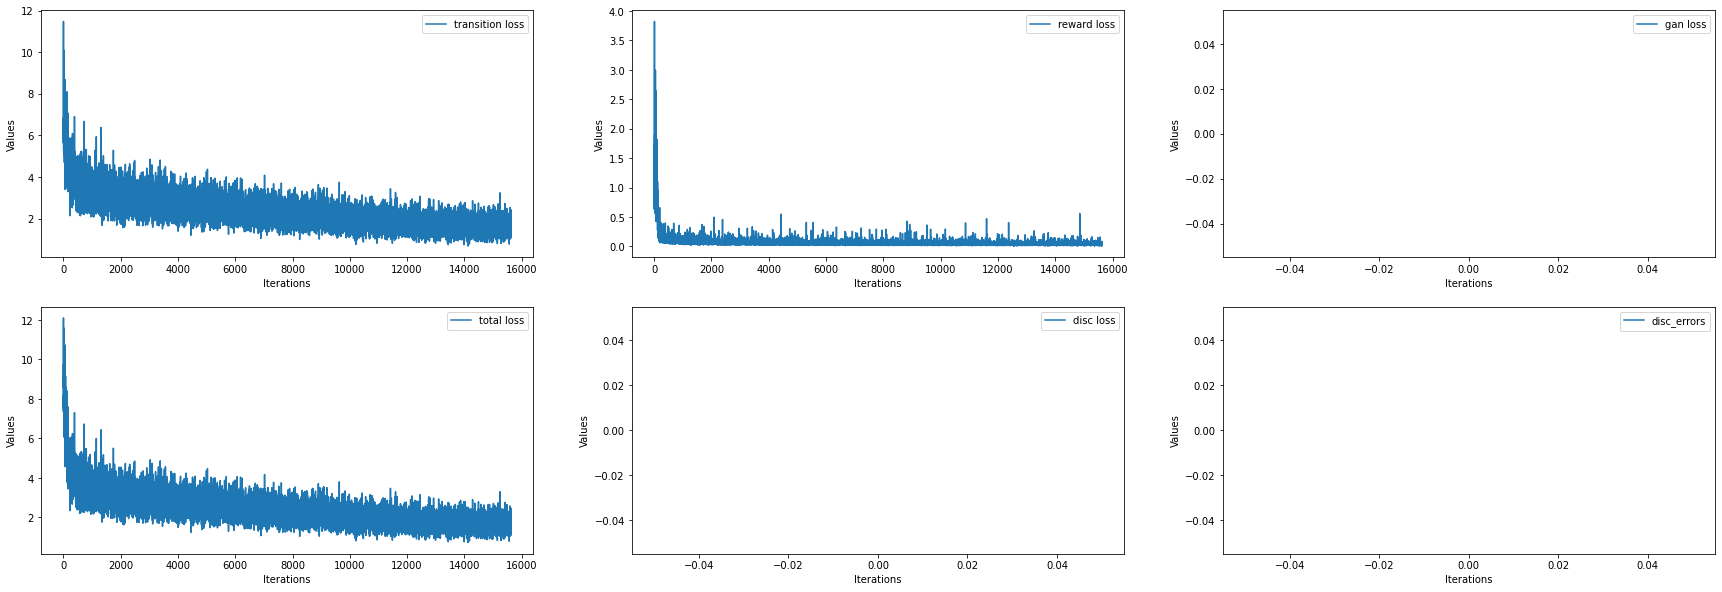

In [9]:
#plt.plot(losses['total'], label='total')

def subplot_setting(ax):
    ax.legend()
    ax.set_ylabel('Values')
    ax.set_xlabel('Iterations')
    
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(30,10))
ax[0][0].plot(losses['transition'], label='transition loss')
ax[0][1].plot(losses['reward'], label='reward loss')
ax[0][2].plot(losses['gan'], label='gan loss')
ax[1][0].plot(losses['total'], label='total loss')
ax[1][1].plot(losses['disc'], label='disc loss')
ax[1][2].plot(losses['disc_errors'], label='disc_errors')

subplot_setting(ax[0][0])
subplot_setting(ax[0][1])
subplot_setting(ax[0][2])
subplot_setting(ax[1][0])
subplot_setting(ax[1][1])
subplot_setting(ax[1][2])

plt.show()

In [10]:
def draw_plot(ax, title, ground_truth, prediction):    
    """    
    title: string    
    ground_truth: (n, 1)    
    prediction: (n, 1)    
    """    
    gt = ground_truth.flatten()    
    pred = prediction.flatten()    

    sorted_indices = gt.view(-1).sort().indices    
    ax.plot(pred[sorted_indices].detach().cpu().numpy(), 'ro', markersize=1, label='Prediction')    
    ax.plot(gt[sorted_indices].detach().cpu().numpy(), 'bo', markersize=0.3, label='Ground Truth')    
    ax.legend(loc='upper left')    
    errors = pred - gt    
    ax.text(0.65, 0.20, 'MSE: {:.2e}'.format(errors.square().mean()), transform=ax.transAxes)                                                                                             
    ax.text(0.65, 0.15, 'MSE STD: {:.2e}'.format(errors.std()), transform=ax.transAxes)                                                                                                   
    ax.set_xlabel('Samples Sorted by Ground Truth Value')                                                                                                                
    ax.set_ylabel('Values')                                                                                                                                              
    ax.set_title(title)
    #ax.set_facecolor('xkcd:grey')
    #plt.savefig(".png"))                                                                                                            
    #plt.clf()

In [11]:
training_range
training = {}
training['state'] = replay_buffer._buffer['state'][training_range[0]:training_range[1], :]
training['action'] = replay_buffer._buffer['action'][training_range[0]:training_range[1], :]
training['reward'] = replay_buffer._buffer['reward'][training_range[0]:training_range[1], :]
training['next_state'] = replay_buffer._buffer['next_state'][training_range[0]:training_range[1], :]
training['prev_state'] = replay_buffer._buffer['prev_state'][training_range[0]:training_range[1], :]
training['prev_action'] = replay_buffer._buffer['prev_action'][training_range[0]:training_range[1], :]

In [12]:
#normalized_state, normalized_action, normalized_next_state = model_agent.preprocess(training['state'],  training['action'], training['next_state'])
#normalized_next_state, normalized_action = model_agent.preprocess(training['next_state'],  training['action'])
#next_state_diff = model_agent.transition(training['state'], training['action'])
next_state_diff, _ = model_agent.transition(training['state'], training['action'], ret_logvar=True)
#next_state_diff, _ = model_agent.transition(training['state'], training['state']-training['prev_state'], training['action'], training['prev_action'], ret_logvar=True)
next_state_pred = training['state'] + next_state_diff
#next_state_pred = model_agent.postprocess(next_state_pred)
reward_pred = model_agent.reward(training['state'], training['action'], next_state_pred.detach())

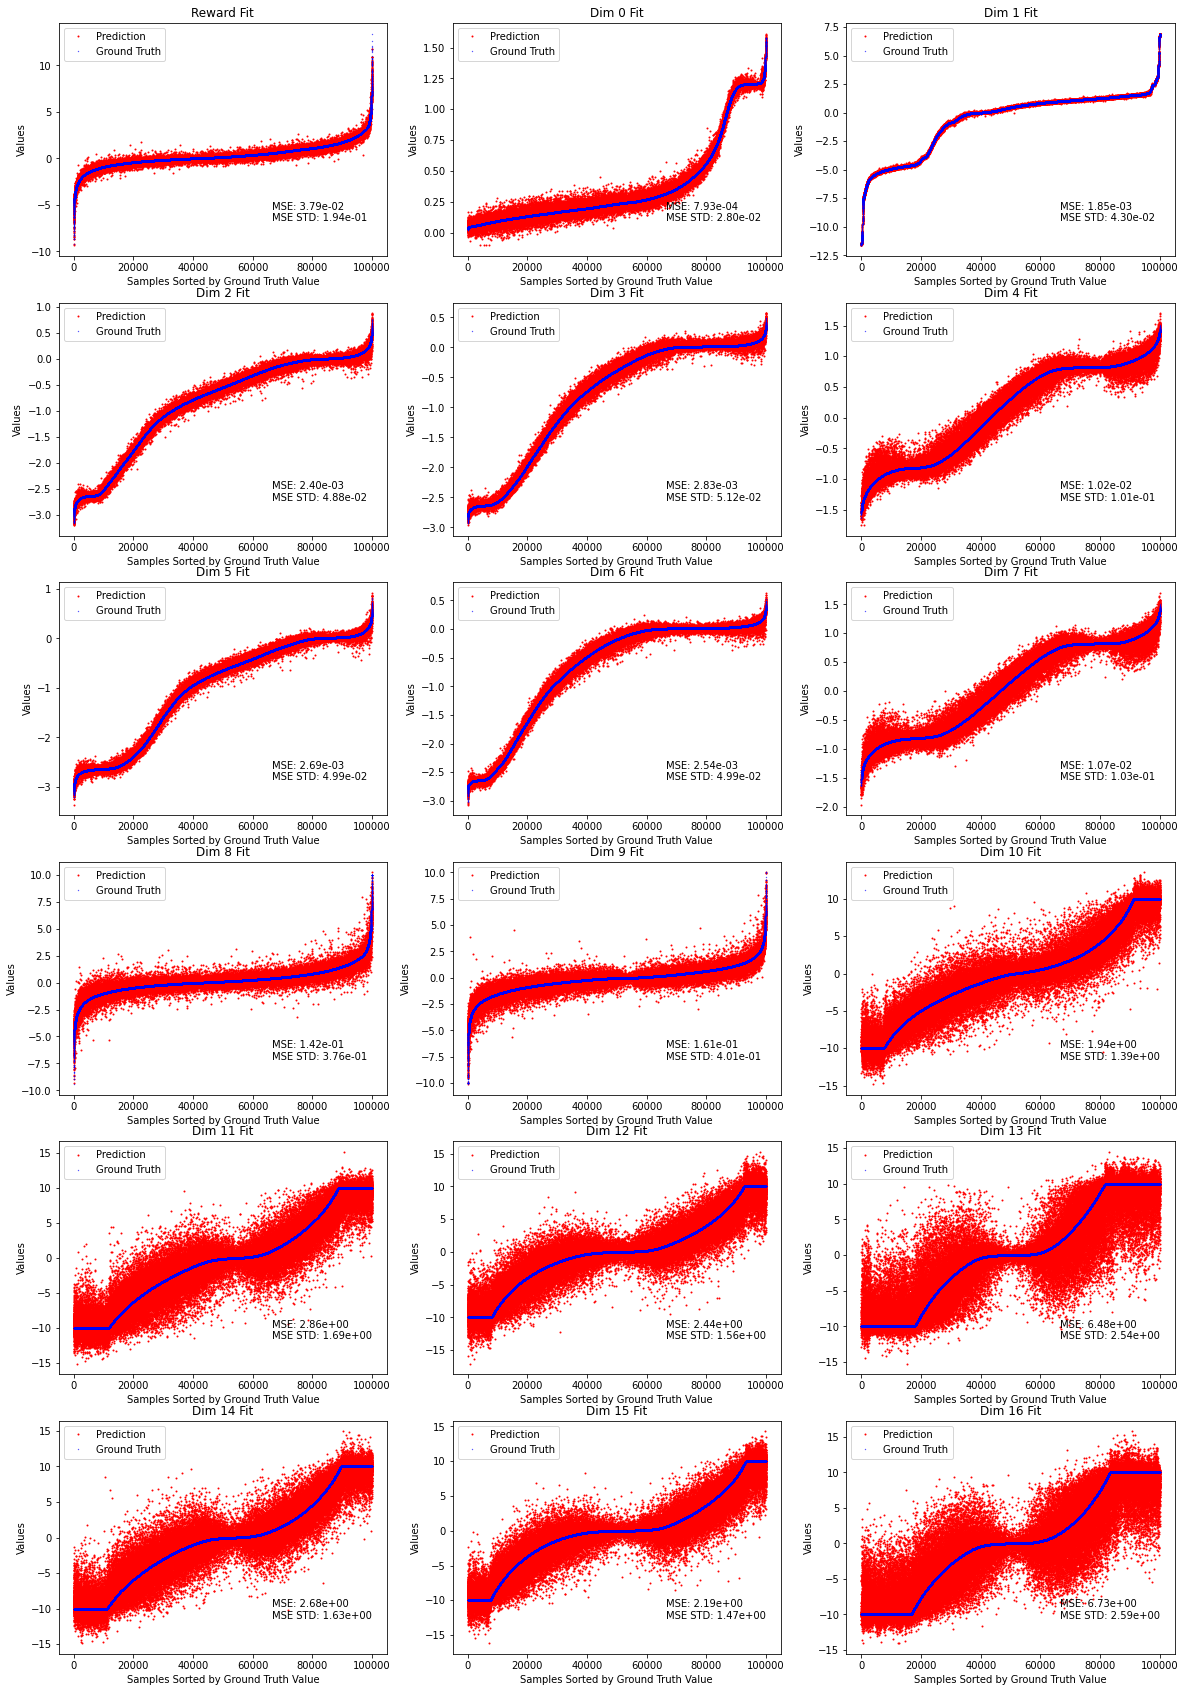

In [13]:
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(20,30))
for i in range(6):
    for j in range(3):
        plot_count =  3 * i + j
        if plot_count == 0:
            draw_plot(ax[i][j], "Reward Fit", training['reward'], reward_pred)
        elif plot_count > BufferFields['state']:
            continue
        else:
            dim = plot_count - 1
            draw_plot(ax[i][j], "Dim {} Fit".format(dim), training['next_state'][:,dim], next_state_pred[:, dim])
            #draw_plot(ax[i][j], "Dim {} Fit".format(dim), normalized_next_state[:,dim], next_state_pred[:, dim])
fig.patch.set_facecolor('white')
plt.savefig("fig.png")

# 5. Validation Plot

In [14]:
#validation_range = (int(90e3), int(100e3))
validation_range = (int(100e3), int(110e3))
#validation_range = (int(900e3), int(901e3))
validation = {}
validation['state'] = replay_buffer._buffer['state'][validation_range[0]:validation_range[1], :]
validation['action'] = replay_buffer._buffer['action'][validation_range[0]:validation_range[1], :]
validation['reward'] = replay_buffer._buffer['reward'][validation_range[0]:validation_range[1], :]
validation['next_state'] = replay_buffer._buffer['next_state'][validation_range[0]:validation_range[1], :]
validation['prev_state'] = replay_buffer._buffer['prev_state'][validation_range[0]:validation_range[1], :]
validation['prev_action'] = replay_buffer._buffer['prev_action'][validation_range[0]:validation_range[1], :]

In [15]:
next_state_diff = model_agent.transition(validation['state'], validation['action'])
#next_state_diff = model_agent.transition(validation['state'], validation['state']-validation['prev_state'], validation['action'], validation['prev_action'])
next_state_pred = validation['state'] + next_state_diff
reward_pred = model_agent.reward(validation['state'], validation['action'], next_state_pred.detach())

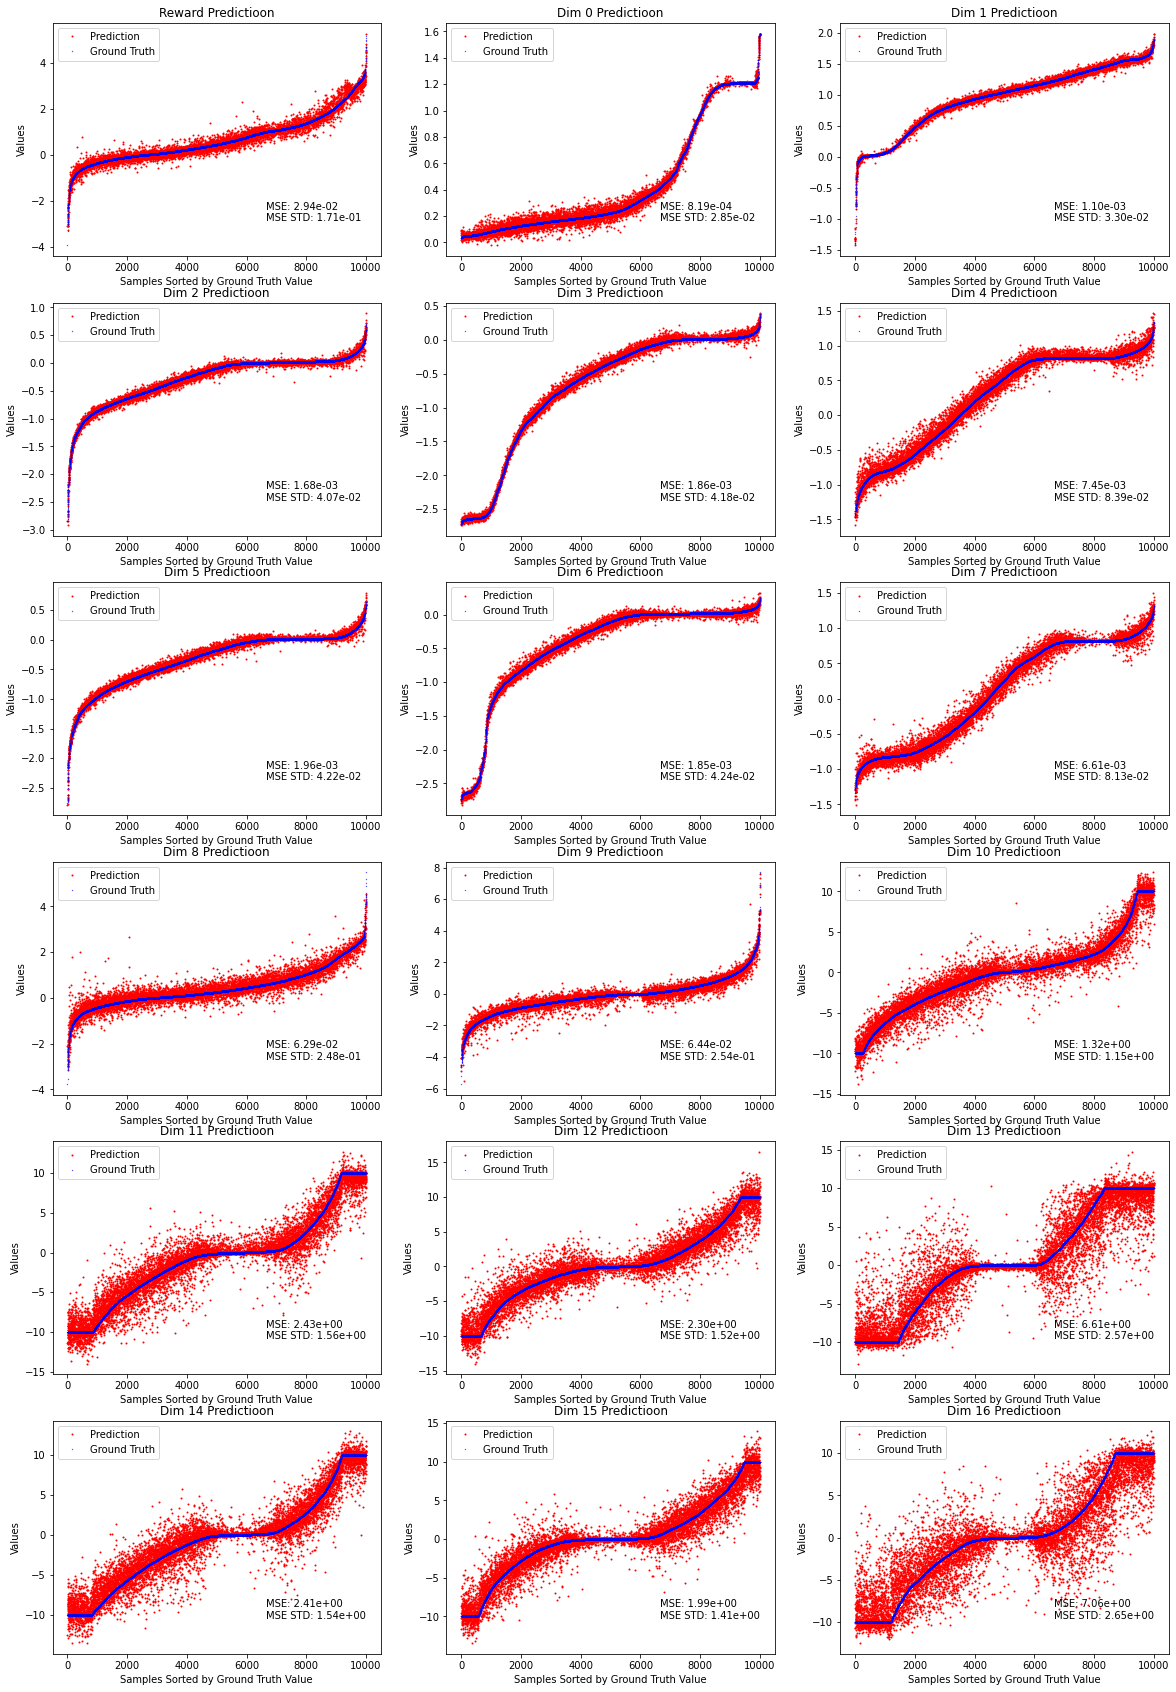

In [16]:
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(20,30))
for i in range(6):
    for j in range(3):
        plot_count =  3 * i + j
        if plot_count == 0: 
            draw_plot(ax[i][j], "Reward Predictioon", validation['reward'], reward_pred)
        elif plot_count > BufferFields['state']:
            continue
        else:
            dim = plot_count - 1
            draw_plot(ax[i][j], "Dim {} Predictioon".format(dim), validation['next_state'][:,dim], next_state_pred[:, dim])
fig.patch.set_facecolor('white')
plt.savefig("fig.png")